<a href="https://colab.research.google.com/github/ICBI/AIMAHEAD_GU/blob/main/Courses/ML_Concepts_in_R/Module_01_Introduction_to_Classification/R_Version_of_Module_02_Unsupervised_Learning_K_means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/AAlogo1.jpg" alt="Powered by" width="150"/>

#AI/ML for Healthcare Applications : Lab 2 Unsupervised Learning: K-means Clustering

Based on material from the Georgetown [Health Informatics and Data Science](https://healthinformatics.georgetown.edu) program and licensed under  [CC4.0](https://creativecommons.org/licenses/by/4.0/)

In this lab, we will explore the kmeans clustering algorithm for unsupervised learning using sklearn

Here we will move on to a class of unsupervised machine learning models: clustering algorithms.
Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in R, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in the kmeans() function of the "cluster" library.
https://cran.r-project.org/web/packages/cluster/index.html

For more information see:https://medium.com/@ahmadbintangarif/k-means-clustering-with-r-abdb10448cc1. And similar resources.

We begin with the standard imports:

**Imports** Note

In [ ]:
#install.packages("ggplot2")
#install.packages("cluster")  # For silhouette score
install.packages("factoextra")  # For visualizing clusters

# Load the libraries
library(ggplot2)
library(cluster)
library(factoextra)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘lazyeval’, ‘carData’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘crosstalk’, ‘estimability’, ‘mvtnorm’, ‘numDeriv’, ‘corrplot’, ‘viridis’, ‘car’, ‘DT’, ‘ellipse’, ‘emmeans’, ‘flashClust’, ‘leaps’, ‘multcompView’, ‘scatterplot3d’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘plyr’, ‘abind’, ‘dendextend’, ‘FactoMineR’, ‘ggpubr’, ‘reshape2’, ‘ggrepel’


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



Conventional k-means requires only a few steps. The first step is to randomly select k centroids, where k is equal to the number of clusters you choose. Centroids are data points representing the center of a cluster.

The main element of the algorithm works by a two-step process called expectation-maximization. The expectation step assigns each data point to its nearest centroid. Then, the maximization step computes the mean of all the points for each cluster and sets the new centroid. Here’s what the conventional version of the k-means algorithm looks like:



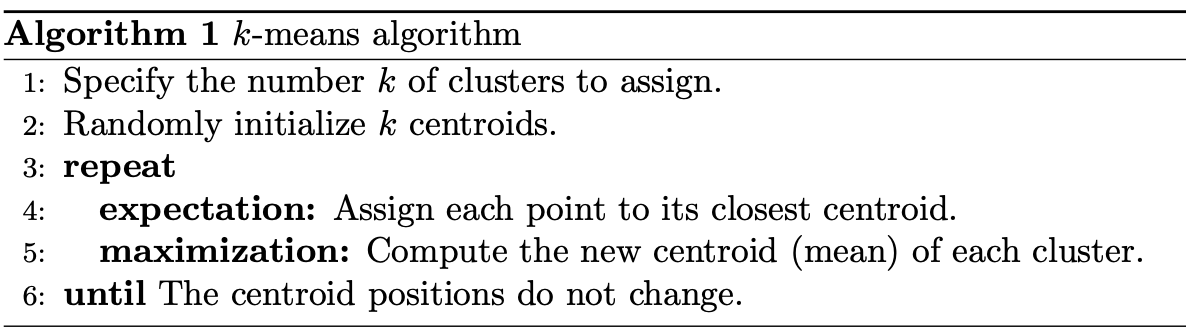

Thankfully, there’s a robust implementation of k-means clustering in R from the popular R package "cluster". You’ll learn how to write a practical implementation of the k-means algorithm using the kmeans() function.

https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/kmeans

## K-means on a syntethic data

### Generate Data

First, let's generate a two-dimensional dataset containing three distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

You can generate the synthetic data for testing the kmeans() implementation using rnorm(), a function in that generates a random points from a normal distribution. rnorm() uses these parameters:

* n is the total number of datasets to generate.
* mean is the mean of the dataset.
* sd is the standard deviation.


* returns a vector

mu is defined by the "centers" matrix, and generates 3 unique distributions.

https://www.rdocumentation.org/packages/compositions/versions/2.0-8/topics/rnorm

In [ ]:
set.seed(41)

# Parameters similar to make_blobs
n_samples <- 200
n_clusters <- 3
cluster_std <- 1.2  # Standard deviation for the clusters

# Define cluster centers manually
centers <- matrix(c(4, 4, -4, -4, 0, 0), ncol = 2)

# Generate points for each cluster by sampling from a normal distribution around the centers
X1 <- mapply(function(mu) rnorm(n_samples / n_clusters, mean = mu, sd = cluster_std), centers[,1])
X2 <- mapply(function(mu) rnorm(n_samples / n_clusters, mean = mu, sd = cluster_std), centers[,2])

# Combine the points and label each point with its cluster
X <- data.frame(X1 = c(X1[,1], X1[,2], X1[,3]),
                X2 = c(X2[,1], X2[,2], X2[,3]),
                label = factor(rep(1:n_clusters, each = n_samples/n_clusters)))

 Check some sample data

Here’s a look at the first five elements for each of the variables returned by the code abouve:

In [ ]:
head(X[, c("X1", "X2")], 5)

,X1,X2
,<dbl>,<dbl>
1,3.046758,-4.961010
2,4.236709,-3.464685
3,5.202045,-4.901038
4,5.546590,-4.679754
5,5.086904,-3.160271


In [ ]:
head(X$label, 5)

[1] 1 1 1 1 1
Levels: 1 2 3

**Data Preprocessing**

Data sets usually contain numerical features that have been measured in different units, such as height (in inches) and weight (in pounds). A machine learning algorithm would consider weight more important than height only because the values for weight are larger and have higher variability from person to person.

Machine learning algorithms need to consider all features on an even playing field. That means the values for all features must be transformed to the same scale.

The process of transforming numerical features to use the same scale is known as feature scaling. It’s an important data preprocessing step for most distance-based machine learning algorithms because it can have a significant impact on the performance of your algorithm.

Scale the data

In [ ]:
X_scaled <- as.data.frame(scale(X[, c("X1", "X2")]))

X_scaled$label <- X$label

**Visualize the data**

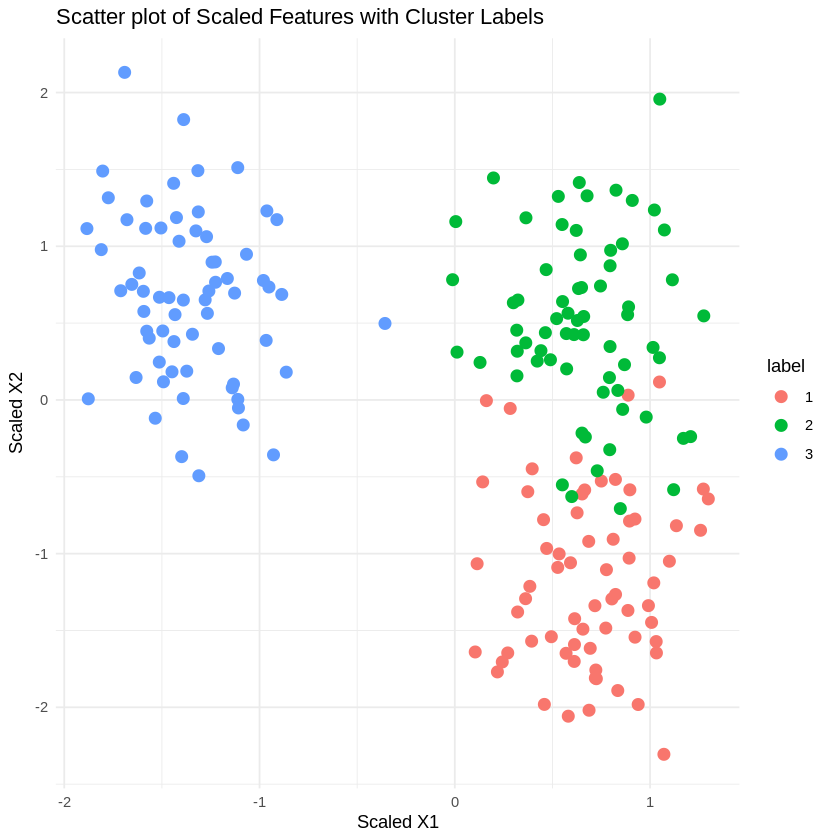

In [ ]:
ggplot(X_scaled, aes(x = X1, y = X2, color = label)) +
  geom_point(size = 3) +  # Equivalent to s=50 in matplotlib (adjust size accordingly)
  scale_color_manual(values = scales::hue_pal()(length(unique(X_scaled$label)))) +  # Adjusts color palette
  labs(title = "Scatter plot of Scaled Features with Cluster Labels",
       x = "Scaled X1", y = "Scaled X2") +
  theme_minimal()

### Fit K-means

Now the data are ready to be clustered. The kmeans() function in the "cluster" package for R.

Here are the parameters used in this example:

* x, the first positional argument, is the dataset.

* `centers` sets k for the clustering step. This is the most important parameter for k-means.

* `nstart` sets the number of initializations to perform. This is important because two runs can converge on different cluster assignments.

* `iter.max` sets the number of maximum iterations for each initialization of the k-means algorithm.

Instantiate the KMeans class with the following arguments:

In [ ]:
set.seed(42)
kmeans_result <- kmeans(X_scaled[, c("X1", "X2")],
                         centers = 3,   # Number of clusters
                         nstart = 10,   # Number of random initializations
                         iter.max = 300 # Maximum iterations
)


The parameter names match the language that was used to describe the k-means algorithm earlier in the tutorial. Now that the k-means class is ready, the next step is to fit it to the data in scaled_features. This will perform ten runs of the k-means algorithm on your data with a maximum of 300 iterations per run:


In [ ]:
print(kmeans_result)

# Add the cluster assignments to the scaled data
X_scaled$cluster <- as.factor(kmeans_result$cluster)

K-means clustering with 3 clusters of sizes 68, 65, 65

Cluster means:
          X1         X2
1  0.7003811 -1.1843729
2  0.6328718  0.5660600
3 -1.3655781  0.6729763

Clustering vector:
  [1] 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 2 2 2 2 2 2 2 1
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 2 3 3 3 3 3 3 3

Within cluster sum of squares by cluster:
[1] 22.31377 22.13038 23.30098
 (between_SS / total_SS =  82.8 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      


### Clustering Quality

The quality of the cluster assignments is determined by computing the sum of the **squared error (SSE)** after the centroids converge, or match the previous iteration’s assignment. The SSE is defined as the sum of the squared Euclidean distances of each point to its closest centroid. Since this is a measure of error, the objective of k-means is to try to minimize this value.

Statistics from the initialization run with the lowest SSE are available as attributes of kmeans result:

In [ ]:
# The lowest SSE value
kmeans_inertia <- kmeans_result$tot.withinss

# Display the inertia value
print(paste("Inertia:", kmeans_inertia))

[1] "Inertia: 67.7451278368977"


In [ ]:
# Final locations of the centroid
cluster_centers <- kmeans_result$centers
print(cluster_centers)

          X1         X2
1  0.7003811 -1.1843729
2  0.6328718  0.5660600
3 -1.3655781  0.6729763


In [ ]:
# The number of iterations required to converge
num_iterations <- kmeans_result$iter
print(num_iterations)

[1] 2


Finally, the cluster assignments are stored as a one-dimensional array in kmeans_result$cluster. Here’s a look at the first five predicted labels:



In [ ]:
labels <- kmeans_result$cluster[1:5]
print(labels)

[1] 1 1 1 1 1


Some labels may not matchThis behavior is normal, as the ordering of cluster labels is dependent on the initialization. Cluster 0 from the first run could be labeled cluster 1 in the second run and vice versa. This doesn’t affect clustering evaluation metrics.



Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

In [ ]:
y_kmeans <- kmeans_result$cluster
print(y_kmeans)

  [1] 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 2 2 2 2 2 2 2 1
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 2 3 3 3 3 3 3 3


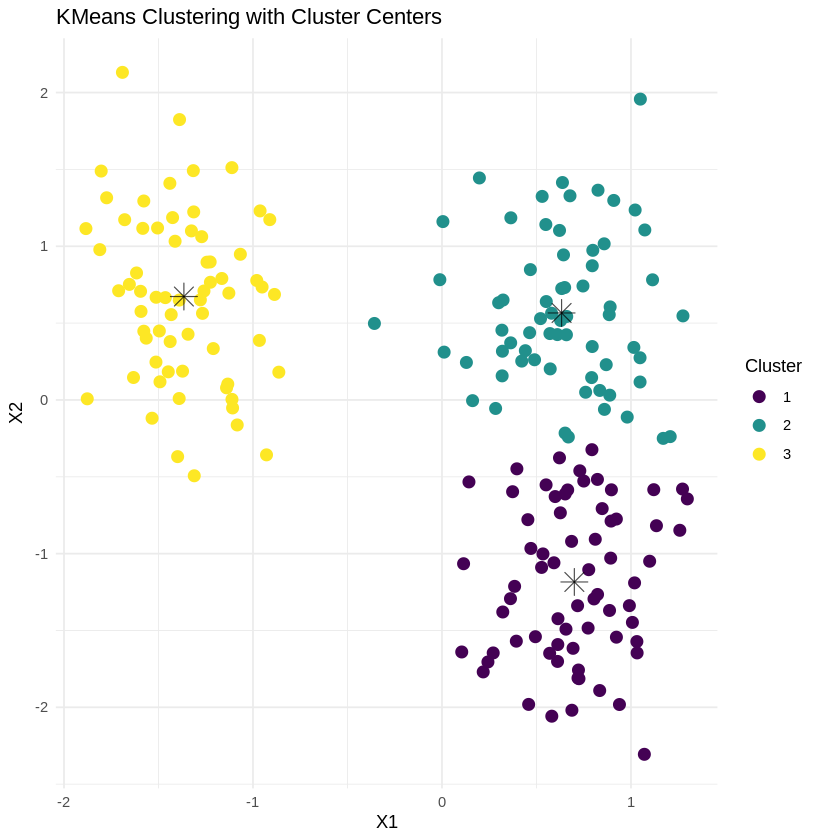

In [ ]:
centers <- kmeans_result$centers
df <- data.frame(X1 = X_scaled[, 1], X2 = X_scaled[, 2], Cluster = as.factor(y_kmeans))

# Create a data frame for cluster centers with proper column names
centers_df <- data.frame(X1 = centers[, 1], X2 = centers[, 2])

# Plot the clusters and cluster centers
ggplot(df, aes(x = X1, y = X2, color = Cluster)) +
  geom_point(size = 3) +  # Plot the data points
  geom_point(data = centers_df, aes(x = X1, y = X2), color = "black", size = 5, shape = 8, alpha = 0.7) +  # Plot cluster centers
  scale_color_viridis_d() +  # Use viridis color palette
  theme_minimal() +
  labs(title = "KMeans Clustering with Cluster Centers")

Since we knew there 3 clusters in our dataset, we used n_clusters=3 when fitting our k means model. Since in many applications, we might not know the number of cluster beforehand, we should try different values for n_clusters and check cluster quality to choose the correct value for the number of clusters

Let's try n_clusters=2 and check the results

In [ ]:
num_of_clusters <- 2
set.seed(41)

# Fit KMeans
kmeans_result <- kmeans(X_scaled, centers = num_of_clusters, nstart = 10)

# Retrieve cluster quality measure (SSE)
sse <- kmeans_result$tot.withinss  # Total within-cluster sum of squares
sse

[1] 235.962

Visualize the clustering

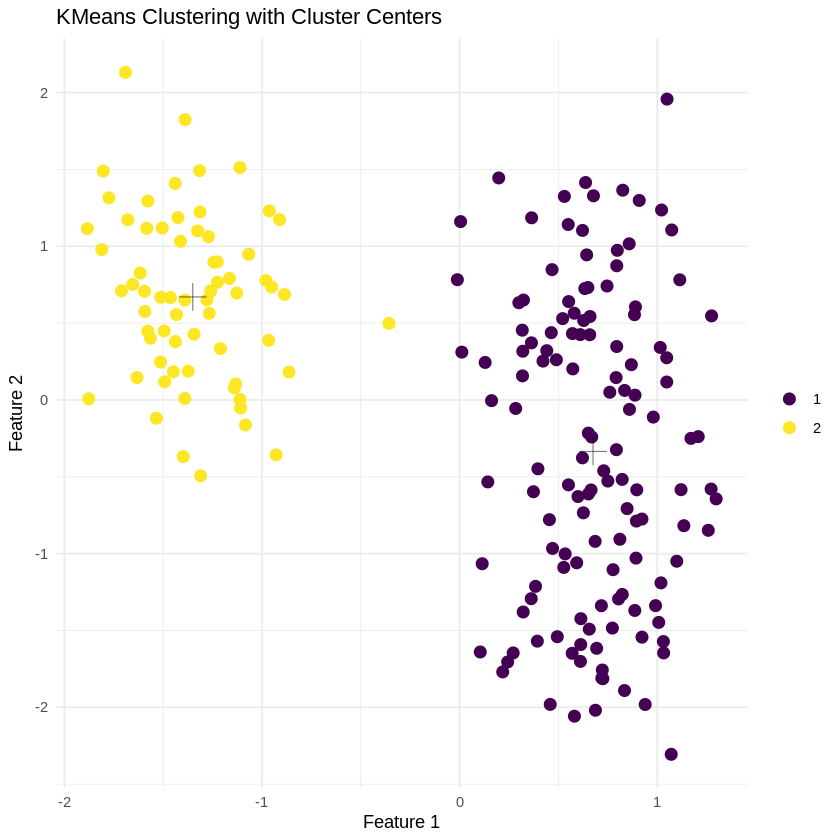

In [ ]:
# Assuming kmeans_result contains the result of the KMeans fitting
# and X_scaled is your scaled data

# Assign cluster labels
y_kmeans <- kmeans_result$cluster

# Create a data frame for plotting
df <- data.frame(X1 = X_scaled[, 1], X2 = X_scaled[, 2], Cluster = as.factor(y_kmeans))

# Extract cluster centers
centers <- kmeans_result$centers
centers_df <- data.frame(X1 = centers[, 1], X2 = centers[, 2])

# Load ggplot2 library (if not already loaded)
library(ggplot2)

# Create the plot
ggplot(df, aes(x = X1, y = X2, color = Cluster)) +
  geom_point(size = 3) +  # Plot the data points
  geom_point(data = centers_df, aes(x = X1, y = X2), color = "black", size = 5, shape = 3, alpha = 0.5) +  # Plot cluster centers
  scale_color_viridis_d() +  # Use viridis color palette
  theme_minimal() +
  labs(title = "KMeans Clustering with Cluster Centers",
       x = "Feature 1",
       y = "Feature 2") +
  theme(legend.title = element_blank())


### Choosing the number of clusters

**Elbow method**

To perform the elbow method, run several k-means, increment k (number of clusters) with each iteration, and record the cluster quality (say **SSE**)

In [ ]:
kmeans_kwargs <- list(
  init = "random",
  n_init = 10,
  max_iter = 300,
  random_state = 41
)

In [ ]:
# A list holds the SSE values for each k
set.seed(kmeans_kwargs$random_state)

# Initialize a vector to store SSE values
sse <- numeric(10)  # Initialize with 10 elements

# Loop through k from 1 to 10
for (k in 1:10) {
  # Fit KMeans with the current number of clusters
  kmeans_result <- kmeans(X_scaled, centers = k, nstart = kmeans_kwargs$n_init)

  # Store the total within-cluster sum of squares (SSE)
  sse[k] <- kmeans_result$tot.withinss
}

# Print the SSE values
print(sse)

 [1] 658.95455 235.96199  77.98066  64.28731  51.94339  41.50116  37.17757
 [8]  32.19830  28.35314  30.28260


**Display the elbow plot**

When you plot SSE as a function of the number of clusters, notice that SSE continues to decrease as you increase k. As more centroids are added, the distance from each point to its closest centroid will decrease.

There’s a sweet spot where the SSE curve starts to bend known as the elbow point. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. In this example, the elbow is located at x=3:

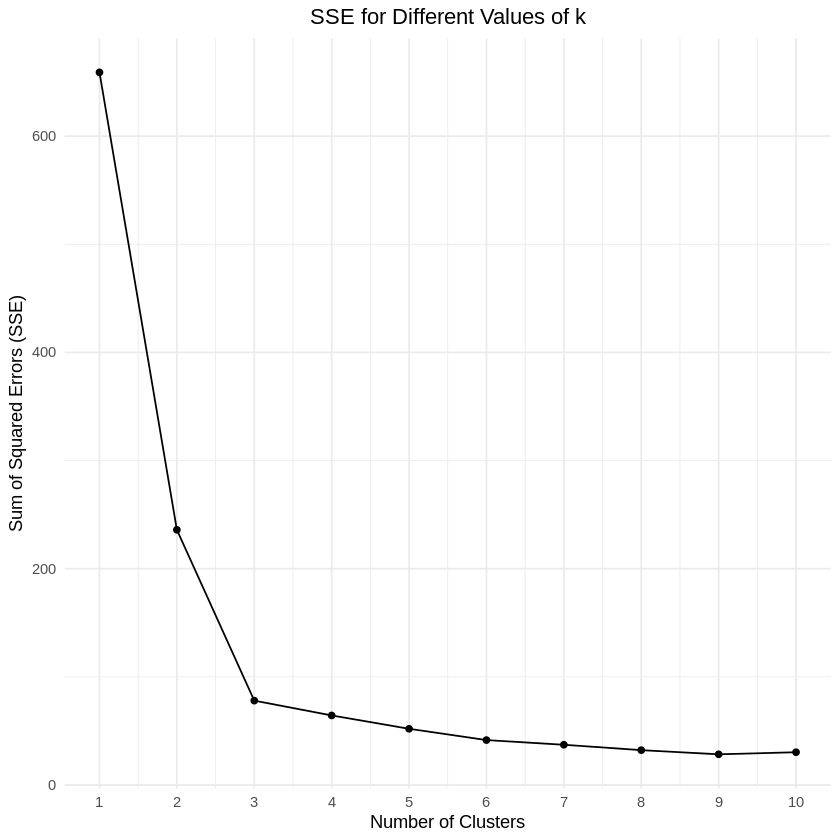

In [ ]:
num_clusters <- 1:10

# Create a data frame for plotting
sse_df <- data.frame(Clusters = num_clusters, SSE = sse)

# Plot the SSE values using ggplot2
ggplot(sse_df, aes(x = Clusters, y = SSE)) +
  geom_line() +                  # Line plot
  geom_point() +                 # Points at each SSE
  scale_x_continuous(breaks = num_clusters) +  # Set x-axis ticks
  labs(title = "SSE for Different Values of k",
       x = "Number of Clusters",
       y = "Sum of Squared Errors (SSE)") +
  theme_minimal() +              # Minimal theme for cleaner look
  theme(plot.title = element_text(hjust = 0.5))

Determining the elbow point in the SSE curve isn’t always straightforward. If you’re having trouble choosing the elbow point of the curve, then you could use one of several R packages,to identify the elbow point programmatically:


Write a function as a elbow locator. We simply find the line that connects the first and last points of the SSE vs. Cluster plot, and see which cluster number maximizes the distance from that fit line.

In [ ]:
# Function to find the elbow point using the first and last points
find_elbow <- function(sse) {
  n <- length(sse)
  x <- 1:n
  y <- sse

  # Calculate the slope and intercept of the line connecting the first and last points
  slope <- (y[n] - y[1]) / (x[n] - x[1])
  intercept <- y[1] - slope * x[1]

  # Calculate the distance from each point to the line
  line_y <- slope * x + intercept
  distances <- abs(y - line_y)

  # Find the index of the maximum distance
  elbow_index <- which.max(distances)

  return(elbow_index)
}

# Find the elbow point
elbow_point <- find_elbow(sse)
cat("The elbow point is at index:", elbow_point, "with SSE value:", sse[elbow_point], "\n")

The elbow point is at index: 3 with SSE value: 77.98066 


**Another clustering quality metric: silhouette coefficient**

The **silhouette coefficient** is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters


Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In the R implementation of the silhouette coefficient, the average silhouette coefficient of all the clusters needs to be summarized into one score by taking the mean of the cluster scores.

https://www.rdocumentation.org/packages/cluster/versions/2.1.8/topics/silhouette

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

Loop through values of k again. This time, instead of computing SSE, compute the silhouette coefficient:


In [ ]:
# A list holds the silhouette coefficients for each k
# Initialize a vector to hold silhouette coefficients
silhouette_coefficients <- numeric(0)
# Notice we start at 2 clusters for silhouette coefficient
# Loop through k values from 2 to 10
for (k in 2:10) {
  # Initialize kmeans
  kmeans_model <- kmeans(X_scaled, centers = k, nstart = 10)  # nstart to replicate the 'n_init' in Python

  # Calculate silhouette score
  score <- silhouette(kmeans_model$cluster, dist(X_scaled))  # Calculate silhouette for the cluster labels

  # Store the average silhouette width
  silhouette_coefficients <- c(silhouette_coefficients, mean(score[, 3]))
}

# Display the silhouette coefficients
silhouette_coefficients




[1] 0.5921361 0.6555140 0.5673248 0.4646405 0.4042414 0.3450302 0.4148296
[8] 0.3957025 0.3790845

Plotting the average silhouette scores for each k shows that the best choice for k is 3 since it has the maximum score:

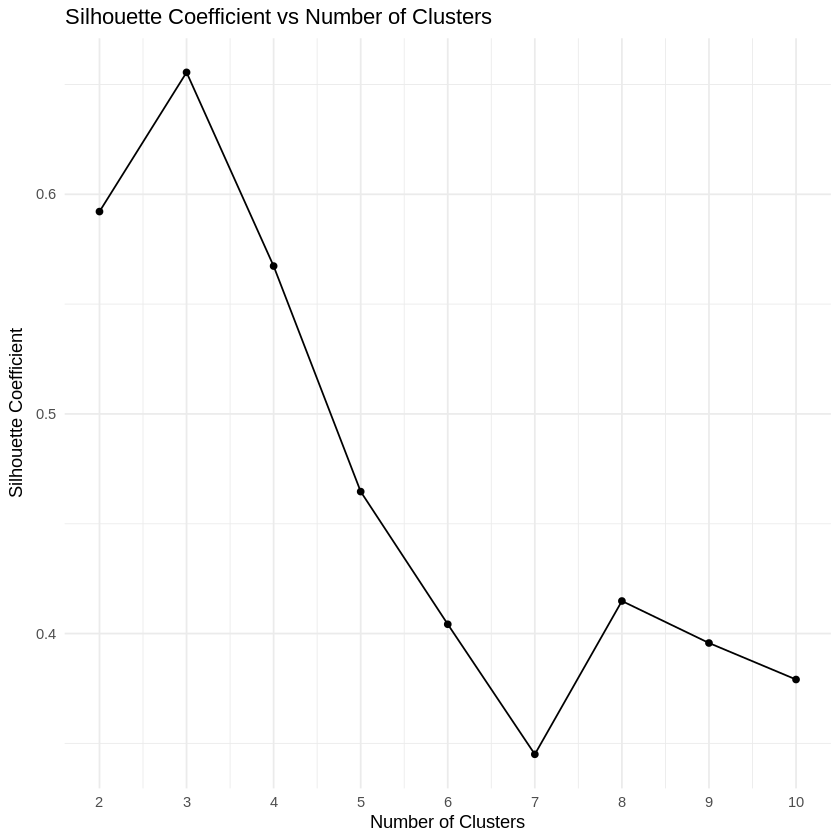

In [ ]:
k_values <- 2:10  # Create a vector for k values

# Create a data frame for plotting
silhouette_data <- data.frame(
  k = k_values,
  silhouette_coefficient = silhouette_coefficients
)

# Plot using ggplot2
ggplot(silhouette_data, aes(x = k, y = silhouette_coefficient)) +
  geom_line() +  # Line plot
  geom_point() +  # Points at each k
  scale_x_continuous(breaks = k_values) +  # X-axis ticks
  labs(x = "Number of Clusters",
       y = "Silhouette Coefficient",
       title = "Silhouette Coefficient vs Number of Clusters") +
  theme_minimal()  # Minimal theme for better aesthetics

### Advanced Clustering Evaluation



Using ground truth labels for evaluation

**Note:** In practice, it’s rare to encounter datasets that have ground truth labels.



The elbow method and silhouette coefficient evaluate clustering performance without the use of ground truth labels. Ground truth labels categorize data points into groups based on assignment by a human or an existing algorithm. These types of metrics do their best to suggest the correct number of clusters but can be deceiving when used without context.

When comparing k-means against a density-based approach on nonspherical clusters, the results from the elbow method and silhouette coefficient rarely match human intuition. This scenario highlights why advanced clustering evaluation techniques are necessary. To visualize an example, import these additional modules:

Note the library packages below may load slowly be paitent (it is feature of R in Colab) :-( Give it 7-10 minutes.

In [ ]:
if (!requireNamespace("dbscan", quietly = TRUE)) {
  install.packages("dbscan")
}

if (!requireNamespace("MASS", quietly = TRUE)) {
  install.packages("MASS")
}
if (!requireNamespace("caret", quietly = TRUE)) {
  install.packages("caret")  # For scaling
}
library(dbscan)
library(MASS)
library(caret)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘pROC’, ‘recipes’



Attaching package: ‘dbscan’


The following object is masked from ‘package:stats’:

    as.dendrogram


Loading required package: lattice



K means which is centroid based algorithm does not perform well with **non-spherical clusters**

Density-based clustering approaches such as DBSCAN are better suited for such data. Density-based clustering connects areas of high example density into clusters. This allows for arbitrary-shaped distributions as long as dense areas can be connected. These algorithms have difficulty with data of varying densities and high dimensions. Further, by design, these algorithms do not assign outliers to clusters.

DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.



Learn about DBSCAN here:

https://en.wikipedia.org/wiki/DBSCAN

https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556

https://www.sthda.com/english/wiki/wiki.php?id_contents=7940

https://www.rdocumentation.org/packages/dbscan/versions/1.2-0/topics/dbscan

When comparing k-means against a density-based approach on nonspherical clusters, the results from the elbow method and silhouette coefficient rarely match human intuition. This scenario highlights why advanced clustering evaluation techniques are necessary. To visualize an example, import these additional modules:



This time, use a custom function to generate synthetic data in the shape of crescents:



In [ ]:
set.seed(42)

library(reshape2)

# Generate moon dataset using a custom function
make_moons <- function(n_samples = 250, noise = 0.05, x_offset = 0.5, y_offset = -0.15) {
  angles <- seq(0, pi, length.out = n_samples / 2)
  crescent1 <- cbind(cos(angles), sin(angles)) + matrix(rnorm(n_samples, sd = noise), ncol = 2)
  crescent2 <- cbind(cos(angles + pi), sin(angles + pi)) + matrix(rnorm(n_samples, sd = noise), ncol = 2)

  # Offset the x-coordinates and y-coordinates of the crescents
  crescent1[, 1] <- crescent1[, 1] - x_offset  # Shift crescent1 left
  crescent1[, 2] <- crescent1[, 2] + y_offset  # Shift crescent1 up
  crescent2[, 1] <- crescent2[, 1] + x_offset  # Shift crescent2 right
  crescent2[, 2] <- crescent2[, 2] - y_offset  # Shift crescent2 down

  # Create labels
  labels1 <- rep(0, n_samples / 2)
  labels2 <- rep(1, n_samples / 2)

  # Combine the data and labels
  data <- rbind(crescent1, crescent2)
  labels <- c(labels1, labels2)

  list(X1 = data[, 1], X2 = data[, 2], label = labels)
}

# Generate the moons dataset
X <- make_moons(n_samples = 250, noise = 0.05)

# Convert to data frame for ggplot
moon_data <- as.data.frame(X)



**Visualize the crescent data**

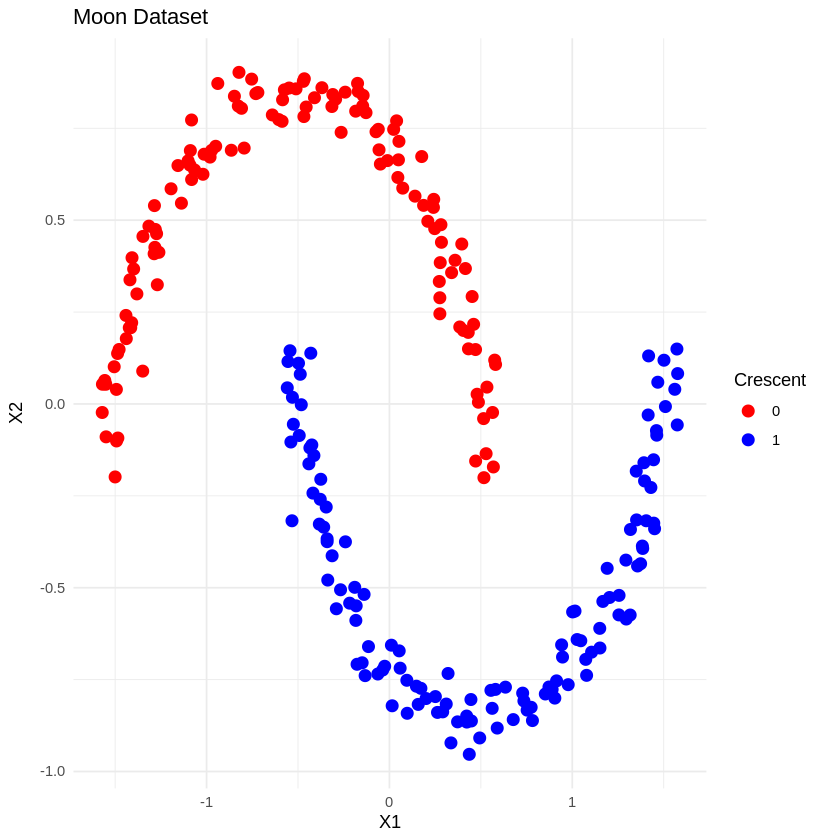

In [ ]:
# Create labels for the clusters
ggplot(moon_data, aes(x = X1, y = X2, color = factor(label))) +
  geom_point(size = 3) +
  scale_color_manual(values = c("red", "blue")) +
  theme_minimal() +
  labs(title = "Moon Dataset", x = "X1", y = "X2", color = "Crescent") +
  theme(legend.position = "right")

**Fit KMeans and DBSCAN**

Fit both a k-means and a DBSCAN algorithm to the new data and visually assess the performance by plotting the cluster assignments:

In [ ]:
# Instantiate k-means and dbscan algorithms
# Load necessary libraries
library(stats)     # for kmeans
library(dbscan)    # for DBSCAN

# Scale the data
X_scaled <- scale(moon_data[,c("X1","X2")])

# K-Means Clustering
kmeans_result <- kmeans(X_scaled, centers = 2, nstart = 10)

# DBSCAN Clustering
dbscan_result <- dbscan::dbscan(X_scaled, eps = 0.6, minPts = 9)
# Display the results
print(kmeans_result)
print(dbscan_result)



K-means clustering with 2 clusters of sizes 124, 126

Cluster means:
          X1         X2
1  0.7350832 -0.8188863
2 -0.7234152  0.8058881

Clustering vector:
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[223] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

Within cluster sum of squares by cluster:
[1]  98.79863 101.27611
 (between_SS / total_SS =  59.8 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      
DBSCAN clustering for 250 ob

In [ ]:
# Compute the silhouette scores for each algorithm
# Compute silhouette scores for K-Means
kmeans_silhouette <- silhouette(kmeans_result$cluster, dist(X_scaled))

# Compute silhouette scores for DBSCAN
# Note: DBSCAN may produce noise points, which we can ignore in silhouette calculation
dbscan_silhouette <- silhouette(dbscan_result$cluster, dist(X_scaled))


In [ ]:
print(paste("K-Means Silhouette Score:", mean(kmeans_silhouette[, 3])))

[1] "K-Means Silhouette Score: 0.502546267546946"


In [ ]:
# Remove noise points (cluster label 0)
# Calculate silhouette scores excluding noise points

print(paste("DBSCAN Silhouette Score: ", mean(dbscan_silhouette[, 3])))


[1] "DBSCAN Silhouette Score:  0.432857733274034"


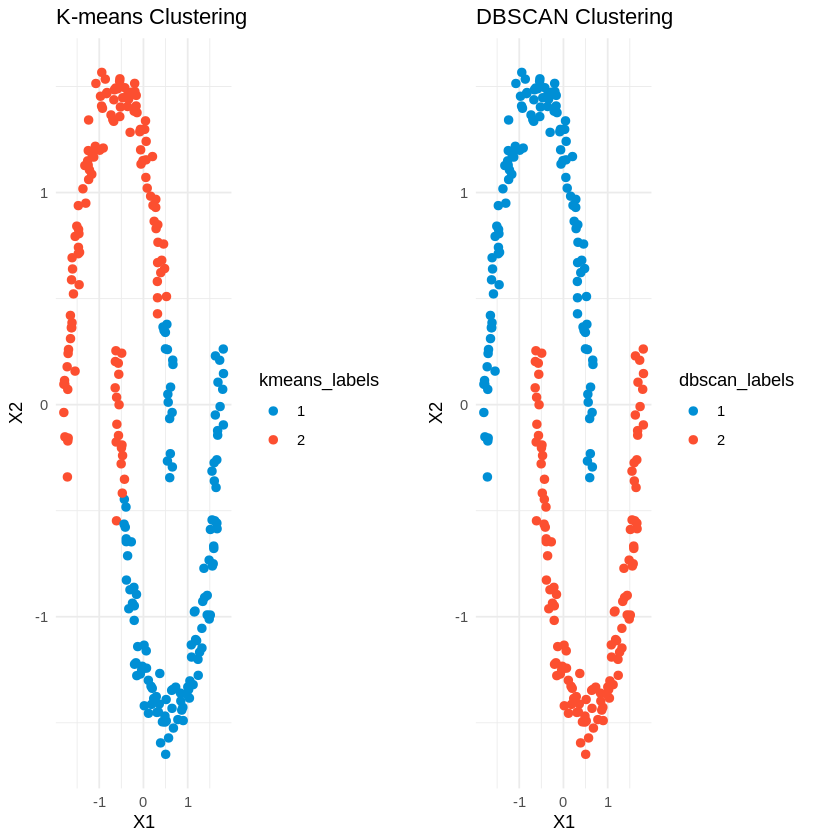

In [ ]:
# Create a dataframe for plotting
df <- data.frame(X1 = X_scaled[, 1], X2 = X_scaled[, 2],
                 kmeans_labels = factor(kmeans_result$cluster),
                 dbscan_labels = factor(dbscan_result$cluster))

# Define color palette, including for noise points (-1 in DBSCAN)
fte_colors <- c("#008fd5", "#fc4f30", "gray", "green")

# Plot K-means results
p1 <- ggplot(df, aes(x = X1, y = X2, color = kmeans_labels)) +
  geom_point(size = 2) +
  scale_color_manual(values = fte_colors) +
  ggtitle("K-means Clustering") +
  theme_minimal()

# Plot DBSCAN results (handle noise points, if present)
p2 <- ggplot(df, aes(x = X1, y = X2, color = dbscan_labels)) +
  geom_point(size = 2) +
  scale_color_manual(values = fte_colors) +
  ggtitle("DBSCAN Clustering") +
  theme_minimal()

# Display the plots side by side
library(gridExtra)
grid.arrange(p1, p2, ncol = 2)

This suggests that you need a better method to compare the performance of these two clustering algorithms.

Since the ground truth labels are known, it’s possible to use a clustering metric that considers labels in its evaluation. You can use the scikit-learn implementation of a common metric called the **adjusted rand index (ARI)**. Unlike the silhouette coefficient, the ARI uses true cluster assignments to measure the similarity between true and predicted labels.

https://www.rdocumentation.org/packages/mclust/versions/6.1/topics/adjustedRandIndex


Given the knowledge of the ground truth class assignments y and our clustering algorithm assignments of the same samples y_pred, the (adjusted or unadjusted) Rand index is a function that measures the similarity of the two assignments, ignoring permutations. One can also view the Rand index as a measure of the percentage of correct decisions made by the algorithm. I

Compare the clustering results of DBSCAN and k-means using ARI as the performance metric:

In [ ]:
install.packages("mclust") #again a slow one to load
library(mclust)

ari_kmeans <- adjustedRandIndex(moon_data$label, kmeans_result$cluster)

# dbscan_model$cluster contains the predicted labels for DBSCAN
ari_dbscan <- adjustedRandIndex(moon_data$label, dbscan_result$cluster)

# Print the ARI values



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
print(paste("ARI for K-means: ", ari_kmeans))

[1] "ARI for K-means:  0.516458189301112"


In [ ]:
print(paste("ARI for DBSCAN: ", ari_dbscan))

[1] "ARI for DBSCAN:  1"


The ARI output values range between -1 and 1. A score close to 0.0 indicates random assignments, and a score close to 1 indicates perfectly labeled clusters.

Based on the above output, you can see that the silhouette coefficient was misleading. ARI shows that DBSCAN is the best choice for the synthetic crescents example as compared to k-means.


## KMeans demo on real-world data

We will be using the gene expression cancer RNA-Seq Data Set from UCI Machine Learning Repositry for this demo.

https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq

This collection of data is part of the RNA-Seq (HiSeq) PANCAN TCGA data set, it is a random extraction of gene expressions of patients having different types of tumor: BRCA, KIRC, COAD, LUAD and PRAD.

Full list of tumor abbreviations: https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations


Imports

In [ ]:
library(ggplot2)
library(cluster)
library(factoextra)  # For PCA and clustering visualization
library(dbscan)
library(dplyr)


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Download and extract the TCGA dataset from UCI:

In [ ]:
# Install necessary packages if not installed
if (!requireNamespace("utils")) install.packages("utils")
if (!requireNamespace("httr")) install.packages("httr")

# Load the necessary libraries
library(httr)  # For downloading files from the web
library(utils)  # For untarring the file

# Define URL and archive name
uci_tcga_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name <- "TCGA-PANCAN-HiSeq-801x20531.tar.gz"
full_download_url <- paste0(uci_tcga_url, archive_name)

# Download the file
download.file(full_download_url, destfile = archive_name, method = "auto")

# Extract the tar.gz file
untar(archive_name, exdir = "TCGA_data")  # exdir specifies the extraction directory

# List extracted files
list.files("TCGA_data")


Loading required namespace: httr


Attaching package: ‘httr’


The following object is masked from ‘package:caret’:

    progress




[1] "TCGA-PANCAN-HiSeq-801x20531"

After the download and extraction is completed, you should have a directory named `TCGA-PANCAN-HiSeq-801x20531`

The kmeans() function requires the data to be in a dataframe, so we need to generate it from the downloaded dataset.

In [ ]:
list.files("TCGA_data/TCGA-PANCAN-HiSeq-801x20531") #find file location

[1] "data.csv"   "labels.csv"

In [ ]:
# Load necessary libraries
if (!requireNamespace("data.table")) install.packages("data.table")

# Load the necessary library
library(data.table)

# Define file paths
datafile <- "TCGA_data/TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file <- "TCGA_data/TCGA-PANCAN-HiSeq-801x20531/labels.csv"

# Load the data (skip the first column, and skip the header)
data <- fread(datafile, skip=1, select = 2:20532, header=FALSE)

# Load the true labels (skip the header, select the second column)
true_label_names <- fread(labels_file, skip=1, select = 2, header=FALSE)

# Convert to data frames
data <- as.data.frame(data)
true_label_names <- as.character(unlist(true_label_names))



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following objects are masked from ‘package:reshape2’:

    dcast, melt




In [ ]:
dim(data)

[1]   801 20531

Check out the first three columns of data for the first five samples as well as the labels for the first five samples:



In [ ]:
data[1:5, 1:3]

,V2,V3,V4
,<dbl>,<dbl>,<dbl>
1,0,2.0172093,3.265527
2,0,0.5927321,1.588421
3,0,3.5117590,4.327199
4,0,3.6636179,4.507649
5,0,2.6557411,2.821547


In [ ]:
true_label_names[1:5]

[1] "PRAD" "LUAD" "PRAD" "PRAD" "BRCA"

The data variable contains all the gene expression values from 20,531 genes. The true_label_names are the cancer types for each of the 881 samples. The first record in data corresponds with the first label in true_labels.

The labels are strings containing abbreviations of cancer types:

* BRCA: Breast invasive carcinoma
* COAD: Colon adenocarcinoma
* KIRC: Kidney renal clear cell carcinoma
* LUAD: Lung adenocarcinoma
* PRAD: Prostate adenocarcinoma


To use these labels in the evaluation methods, you first need to convert the abbreviations to integers with LabelEncoder:

In [ ]:
true_labels <- as.numeric(factor(true_label_names)) - 1

In [ ]:
true_labels[1:5]


[1] 4 3 4 4 0

In [ ]:
# Get the unique classes (levels) from the factor
label_classes <- levels(factor(true_label_names))
print(label_classes)


[1] "BRCA" "COAD" "KIRC" "LUAD" "PRAD"


Define number of clusters as unique cancer types

In [ ]:
n_clusters <- length(levels(factor(true_label_names)))
print(n_clusters)

[1] 5


In practical machine learning pipelines, it’s common for the data to undergo multiple sequences of transformations before it feeds into a clustering algorithm. You learned about the importance of one of these transformation steps, feature scaling, earlier in this tutorial. An equally important data transformation technique is dimensionality reduction, which reduces the number of features in the dataset by either removing or combining them.

**Dimensionality reduction** techniques help to address a problem with machine learning algorithms known as the curse of dimensionality. In short, as the number of features increases, the feature space becomes sparse. This sparsity makes it difficult for algorithms to find data objects near one another in higher-dimensional space. Since the gene expression dataset has over 20,000 features, it qualifies as a great candidate for dimensionality reduction.

**Principal Component Analysis (PCA)** is one of many dimensionality reduction techniques. PCA transforms the input data by projecting it into a lower number of dimensions called components. The components capture the variability of the input data through a linear combination of the input data’s features.

A full description of PCA is out of scope for this demo, but you can learn more about it here:

https://www.r-bloggers.com/2021/05/principal-component-analysis-pca-in-r/



**Create PCA to Kmeans pipeline**

Create pipeline to first reduce the number of features and then apply kmeans

In R, you can create a preprocessing pipeline simply by applying functions sequentially without a formal pipeline structure, as R doesn't have a built-in pipeline feature like Python's Pipeline. Below is how you can replicate the MinMaxScaler and PCA steps from Python using base R functions and the prcomp function for PCA.

In [ ]:
# Load required libraries
library(stats)   # for kmeans and prcomp
library(dplyr)   # for data manipulation

# Step 1: Remove zero variance columns
# Create a logical vector identifying non-zero variance columns
non_zero_var_columns <- sapply(data, function(x) var(x) != 0)

# Subset the data to keep only non-zero variance columns
data_non_zero_var <- data[, non_zero_var_columns]

# Step 2: Scale the data
scaled_data <- as.data.frame(scale(data_non_zero_var))

# Step 3: Perform PCA
pca_result <- prcomp(scaled_data, center = TRUE, scale. = TRUE)



Compute silhouette coefficient.

First we need to extract the preprocessed data. How?

In [ ]:
# Get the first two principal components
preprocessed_data <- as.data.frame(pca_result$x[, 1:2])  # Select first two principal components


Check preprocessed data

In [ ]:

# Print the preprocessed data
print(head(preprocessed_data))  # Display the first few rows of the preprocessed data


        PC1        PC2
1 -57.41112  95.351405
2 -16.90887   0.732013
3 -70.30129 -19.291273
4 -49.13089  -9.221824
5 -18.12121 -51.295747
6 -19.16302  23.703610


Get cluster assignments

In [ ]:
# Project the data onto the first two principal components
pca_data <- data.frame(pca_result$x[, 1:2])

# Perform KMeans clustering
n_clusters <- length(unique(true_labels))
set.seed(42)  # For reproducibility
kmeans_result <- kmeans(pca_data, centers = n_clusters, nstart = 50)

# Add the cluster labels to the PCA data
pca_data$cluster <- as.factor(kmeans_result$cluster)

pca_data$cluster

[1] 5 1 3 3 2 3 4 1 2 3 1 4 1 5 2 2 1 4 4 3 2 1 1 3 4 1 3 2 1 2 2 2 4 5 3 2 4
 [38] 1 3 5 4 3 1 4 4 2 5 3 2 1 2 3 2 3 3 3 2 3 4 1 1 1 2 1 3 3 1 3 4 3 4 1 3 1
 [75] 2 3 2 5 1 3 2 3 2 2 5 3 2 3 4 3 3 3 2 5 2 3 3 2 1 1 2 4 2 4 1 4 3 3 3 1 5
[112] 2 1 3 2 4 4 4 2 2 1 4 3 3 1 3 3 2 4 3 3 3 5 1 2 4 4 2 4 3 2 3 2 4 1 3 5 2
[149] 1 3 1 1 2 2 1 1 2 1 3 1 5 1 4 1 1 1 3 4 1 2 4 1 2 3 2 3 1 1 1 4 3 4 2 1 3
[186] 1 1 1 2 1 1 4 5 2 3 2 5 2 3 1 2 4 4 4 4 2 5 3 1 1 1 2 1 3 3 1 2 2 1 1 4 1
[223] 4 4 1 2 4 3 2 1 5 2 3 5 4 1 4 3 1 4 4 2 3 1 1 3 4 1 1 3 2 3 1 1 1 4 5 1 1
[260] 2 1 3 1 3 3 3 1 2 2 4 4 2 3 5 4 3 2 2 4 2 2 2 5 3 1 2 2 2 4 4 4 4 5 2 2 4
[297] 2 2 1 1 1 2 5 3 3 2 2 2 5 1 2 2 3 3 1 3 4 3 4 4 2 3 1 2 2 2 2 4 2 2 3 3 4
[334] 2 1 1 4 2 3 3 1 2 2 1 5 1 2 2 3 1 2 4 2 3 1 1 2 4 2 2 3 3 3 3 4 3 4 1 2 4
[371] 2 3 3 1 3 5 4 3 2 3 4 4 3 3 3 2 5 3 4 5 3 3 2 2 1 1 4 1 2 4 3 2 2 3 1 3 5
[408] 2 3 2 3 3 1 3 3 2 2 2 2 1 2 1 2 4 1 2 2 1 4 3 4 5 2 3 1 4 2 2 4 2 1 3 2 3
[445] 5 3 4 1 5 3 3 2 2 2 2 4 2 1 4 2 2 3 1 4 3 1 3 1 4 4 3 1 4 3 1 3 2 1 1 1 1
[482] 2 4 1 1 5 1 5 2 2 3 3 4 3 3 3 3 5 1 1 2 3 2 5 4 2 2 3 2 2 3 4 1 3 2 2 1 1
[519] 3 1 2 4 3 4 4 5 1 1 1 4 3 3 2 4 4 2 1 1 4 3 1 2 3 1 2 1 2 4 1 3 1 3 4 3 4
[556] 4 3 1 3 4 2 3 3 1 1 1 3 4 2 2 3 3 2 1 2 4 1 3 3 3 3 2 2 4 3 5 3 1 3 1 5 4
[593] 4 2 2 4 4 3 2 1 3 3 4 2 1 2 1 3 1 5 3 1 2 5 2 4 2 1 1 2 1 3 2 4 3 1 2 2 4
[630] 1 2 2 2 5 3 1 1 3 2 2 1 2 2 4 3 1 4 4 1 4 3 1 5 4 2 2 1 1 3 1 3 2 3 2 2 3
[667] 3 4 2 4 3 2 2 1 2 1 4 2 2 4 3 2 1 4 3 1 1 1 5 4 3 1 3 3 2 1 2 1 4 4 4 1 1
[704] 4 1 2 1 5 2 3 2 4 1 1 1 1 4 1 4 2 1 1 2 5 4 2 3 2 3 4 4 1 3 4 3 5 4 2 1 1
[741] 3 2 5 3 3 3 1 2 4 1 2 2 1 2 3 1 2 1 2 1 2 3 1 1 4 4 3 3 2 2 2 3 2 1 1 1 1
[778] 4 3 1 3 4 2 5 3 3 4 2 2 1 2 2 2 2 1 1 2 3 1 3 3
Levels: 1 2 3 4 5

Compute silhouette coefficient.

In [ ]:
# Silhouette score calculation
silhouette_score <- silhouette(kmeans_result$cluster, dist(pca_data[, 1:2]))
avg_sil_width <- mean(silhouette_score[, 3], na.rm = TRUE)  # Include na.rm to avoid NA values

# Print the average silhouette width
print(paste("Average Silhouette Width: ", avg_sil_width))

[1] "Average Silhouette Width:  0.389861520455917"


The Adjusted Rand Index (ARI) is a measure used to evaluate the similarity between two data clusterings, adjusting for the chance grouping of elements. It is particularly useful in clustering analysis to determine how well the clustering results match the ground truth. We can calculate ARI, too, since the ground truth cluster labels are available:


In [ ]:
ari <- adjustedRandIndex(true_labels, kmeans_result$cluster)
print(paste("Adjusted Rand Index:", ari))

[1] "Adjusted Rand Index: 0.394998781649894"


As mentioned earlier, the scale for each of these clustering performance metrics ranges from -1 to 1. A silhouette coefficient of 0 indicates that clusters are significantly overlapping one another, and a silhouette coefficient of 1 indicates clusters are well-separated. An ARI score of 0 indicates that cluster labels are randomly assigned, and an ARI score of 1 means that the true labels and predicted labels form identical clusters.

Since you specified n_components=2 in the PCA step of the k-means clustering pipeline, you can also visualize the data in the context of the true labels and predicted labels. We will pllot the results using a pandas DataFrame and the seaborn plotting library:

In [ ]:
true_label_names

[1] "PRAD" "LUAD" "PRAD" "PRAD" "BRCA" "PRAD" "KIRC" "PRAD" "BRCA" "PRAD"
 [11] "BRCA" "KIRC" "PRAD" "BRCA" "BRCA" "BRCA" "LUAD" "KIRC" "KIRC" "PRAD"
 [21] "BRCA" "KIRC" "LUAD" "BRCA" "KIRC" "LUAD" "COAD" "BRCA" "BRCA" "BRCA"
 [31] "BRCA" "BRCA" "KIRC" "BRCA" "PRAD" "BRCA" "KIRC" "LUAD" "BRCA" "BRCA"
 [41] "KIRC" "PRAD" "PRAD" "KIRC" "KIRC" "BRCA" "PRAD" "COAD" "BRCA" "LUAD"
 [51] "BRCA" "LUAD" "BRCA" "PRAD" "COAD" "BRCA" "BRCA" "COAD" "KIRC" "BRCA"
 [61] "LUAD" "KIRC" "BRCA" "LUAD" "PRAD" "COAD" "BRCA" "PRAD" "KIRC" "BRCA"
 [71] "KIRC" "BRCA" "BRCA" "LUAD" "BRCA" "LUAD" "BRCA" "KIRC" "PRAD" "COAD"
 [81] "BRCA" "PRAD" "BRCA" "BRCA" "PRAD" "PRAD" "BRCA" "BRCA" "KIRC" "BRCA"
 [91] "PRAD" "PRAD" "BRCA" "BRCA" "BRCA" "PRAD" "COAD" "BRCA" "PRAD" "BRCA"
[101] "BRCA" "KIRC" "BRCA" "KIRC" "LUAD" "KIRC" "LUAD" "COAD" "LUAD" "LUAD"
[111] "PRAD" "BRCA" "LUAD" "PRAD" "BRCA" "KIRC" "KIRC" "KIRC" "BRCA" "BRCA"
[121] "LUAD" "KIRC" "LUAD" "BRCA" "PRAD" "PRAD" "PRAD" "BRCA" "KIRC" "LUAD"
[131] "COAD" "BRCA" "COAD" "BRCA" "BRCA" "KIRC" "LUAD" "BRCA" "KIRC" "COAD"
[141] "BRCA" "PRAD" "BRCA" "KIRC" "LUAD" "COAD" "PRAD" "BRCA" "LUAD" "LUAD"
[151] "LUAD" "LUAD" "BRCA" "BRCA" "LUAD" "BRCA" "BRCA" "PRAD" "PRAD" "LUAD"
[161] "PRAD" "LUAD" "KIRC" "BRCA" "PRAD" "LUAD" "COAD" "KIRC" "LUAD" "BRCA"
[171] "KIRC" "LUAD" "BRCA" "LUAD" "BRCA" "BRCA" "BRCA" "PRAD" "BRCA" "KIRC"
[181] "COAD" "KIRC" "BRCA" "PRAD" "PRAD" "PRAD" "LUAD" "LUAD" "BRCA" "LUAD"
[191] "LUAD" "KIRC" "LUAD" "PRAD" "LUAD" "BRCA" "BRCA" "BRCA" "LUAD" "LUAD"
[201] "BRCA" "KIRC" "KIRC" "KIRC" "KIRC" "PRAD" "BRCA" "PRAD" "BRCA" "LUAD"
[211] "LUAD" "BRCA" "PRAD" "BRCA" "PRAD" "BRCA" "BRCA" "BRCA" "LUAD" "BRCA"
[221] "KIRC" "LUAD" "KIRC" "KIRC" "LUAD" "BRCA" "KIRC" "PRAD" "BRCA" "LUAD"
[231] "LUAD" "PRAD" "COAD" "BRCA" "KIRC" "PRAD" "KIRC" "COAD" "BRCA" "KIRC"
[241] "KIRC" "LUAD" "PRAD" "PRAD" "LUAD" "LUAD" "KIRC" "BRCA" "BRCA" "COAD"
[251] "BRCA" "PRAD" "COAD" "BRCA" "PRAD" "KIRC" "PRAD" "PRAD" "PRAD" "BRCA"
[261] "COAD" "COAD" "LUAD" "COAD" "COAD" "PRAD" "LUAD" "BRCA" "BRCA" "KIRC"
[271] "KIRC" "BRCA" "COAD" "PRAD" "KIRC" "PRAD" "BRCA" "BRCA" "KIRC" "BRCA"
[281] "BRCA" "BRCA" "BRCA" "LUAD" "LUAD" "BRCA" "BRCA" "BRCA" "KIRC" "KIRC"
[291] "KIRC" "KIRC" "BRCA" "BRCA" "BRCA" "KIRC" "BRCA" "BRCA" "LUAD" "PRAD"
[301] "BRCA" "BRCA" "COAD" "LUAD" "PRAD" "BRCA" "BRCA" "BRCA" "COAD" "BRCA"
[311] "PRAD" "BRCA" "COAD" "LUAD" "LUAD" "PRAD" "KIRC" "BRCA" "KIRC" "KIRC"
[321] "LUAD" "COAD" "KIRC" "BRCA" "BRCA" "BRCA" "BRCA" "KIRC" "BRCA" "BRCA"
[331] "PRAD" "BRCA" "KIRC" "BRCA" "LUAD" "PRAD" "KIRC" "BRCA" "PRAD" "COAD"
[341] "BRCA" "BRCA" "BRCA" "LUAD" "LUAD" "LUAD" "BRCA" "BRCA" "PRAD" "LUAD"
[351] "BRCA" "KIRC" "BRCA" "COAD" "COAD" "LUAD" "BRCA" "KIRC" "BRCA" "BRCA"
[361] "BRCA" "COAD" "LUAD" "COAD" "KIRC" "PRAD" "KIRC" "BRCA" "BRCA" "KIRC"
[371] "BRCA" "COAD" "PRAD" "LUAD" "PRAD" "BRCA" "KIRC" "PRAD" "BRCA" "COAD"
[381] "KIRC" "KIRC" "COAD" "COAD" "PRAD" "BRCA" "BRCA" "COAD" "KIRC" "BRCA"
[391] "PRAD" "BRCA" "BRCA" "BRCA" "LUAD" "LUAD" "KIRC" "LUAD" "BRCA" "KIRC"
[401] "COAD" "PRAD" "BRCA" "LUAD" "PRAD" "BRCA" "BRCA" "BRCA" "LUAD" "BRCA"
[411] "BRCA" "PRAD" "BRCA" "PRAD" "COAD" "BRCA" "LUAD" "BRCA" "BRCA" "LUAD"
[421] "BRCA" "BRCA" "BRCA" "KIRC" "LUAD" "PRAD" "BRCA" "PRAD" "KIRC" "BRCA"
[431] "KIRC" "COAD" "BRCA" "PRAD" "LUAD" "KIRC" "BRCA" "BRCA" "KIRC" "BRCA"
[441] "LUAD" "BRCA" "BRCA" "PRAD" "COAD" "BRCA" "KIRC" "LUAD" "PRAD" "BRCA"
[451] "PRAD" "BRCA" "BRCA" "BRCA" "BRCA" "KIRC" "LUAD" "BRCA" "KIRC" "BRCA"
[461] "BRCA" "LUAD" "LUAD" "KIRC" "COAD" "PRAD" "COAD" "BRCA" "KIRC" "KIRC"
[471] "BRCA" "PRAD" "KIRC" "COAD" "LUAD" "LUAD" "BRCA" "PRAD" "PRAD" "BRCA"
[481] "PRAD" "LUAD" "KIRC" "PRAD" "BRCA" "LUAD" "PRAD" "LUAD" "BRCA" "BRCA"
[491] "COAD" "LUAD" "KIRC" "COAD" "LUAD" "BRCA" "PRAD" "BRCA" "BRCA" "PRAD"
[501] "BRCA" "COAD" "BRCA" "COAD" "KIRC" "BRCA" "BRCA" "LUAD" "LUAD" "LUAD"
[511] "COAD" "KIRC" "LUAD" "LUAD" "BRCA" "BRCA" "KIRC" "PRAD" "LUAD" "PRAD"
[521] "BRCA" "KIRC" "BRCA" "KIRC" "KIRC" "PRAD" "P

In [ ]:
pcadf <- data.frame(
  component_1 = preprocessed_data[, 1],
  component_2 = preprocessed_data[, 2],
  predicted_cluster = kmeans_result$cluster,
  true_label = true_label_names  # Assuming label_encoder$levels stores the original labels
)



In [ ]:
# View the first few rows of the data frame
head(pcadf)

,component_1,component_2,predicted_cluster,true_label
,<dbl>,<dbl>,<int>,<chr>
1,-57.41112,95.351405,5,PRAD
2,-16.90887,0.732013,1,LUAD
3,-70.30129,-19.291273,3,PRAD
4,-49.13089,-9.221824,3,PRAD
5,-18.12121,-51.295747,2,BRCA
6,-19.16302,23.703610,3,PRAD


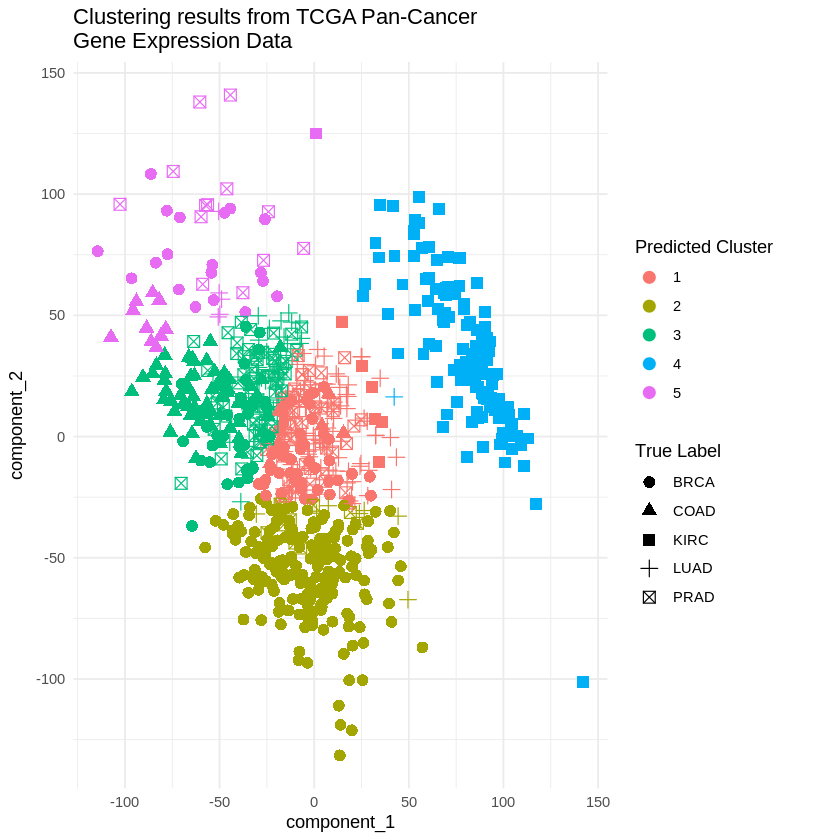

In [ ]:
pcadf$true_label <- as.factor(pcadf$true_label)

# Create the scatter plot
ggplot(data = pcadf, aes(x = component_1, y = component_2)) +
  geom_point(aes(color = as.factor(predicted_cluster), shape = true_label), size = 3) +
  labs(title = "Clustering results from TCGA Pan-Cancer\nGene Expression Data",
       color = "Predicted Cluster",
       shape = "True Label") +
  theme_minimal() +
  theme(legend.position = "right") # Adjust legend position

Your first k-means clustering pipeline performed well, but there’s still room to improve. That’s why you went through the trouble of building the pipeline: you can tune the parameters to get the most desirable clustering results.

The process of parameter tuning consists of sequentially altering one of the input values of the algorithm’s parameters and recording the results. At the end of the parameter tuning process, you’ll have a set of performance scores, one for each new value of a given parameter. Parameter tuning is a powerful method to maximize performance from your clustering pipeline.

By setting the PCA parameter n_components=2, you squished all the features into two components, or dimensions. This value was convenient for visualization on a two-dimensional plot. But using only two components means that the PCA step won’t capture all of the explained variance of the input data.

Explained variance measures the discrepancy between the PCA-transformed data and the actual input data. The relationship between n_components and explained variance can be visualized in a plot to show you how many components you need in your PCA to capture a certain percentage of the variance in the input data. You can also use clustering performance metrics to evaluate how many components are necessary to achieve satisfactory clustering results.

In this example, you’ll use clustering performance metrics to identify the appropriate number of components in the PCA step.

Iterate over a range of n_components and record evaluation metrics for each iteration:

In [ ]:
install.packages("clValid")
install.packages("cluster")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Load necessary libraries
library(clValid)
library(cluster)
# Function to remove constant columns
remove_constant_columns <- function(data) {
    return(data[, sapply(data, var) != 0])
}

# Remove constant columns from the data
data_clean <- remove_constant_columns(data)

# Empty lists to hold evaluation metrics
silhouette_scores <- numeric(0)
ari_scores <- numeric(0)

# Loop over the number of components for PCA
for (n in 2:10) {
    # Set the number of components for PCA in your preprocessor
    pca_model <- prcomp(data_clean, center = TRUE, scale. = TRUE, rank. = n)
    pca_data <- as.data.frame(pca_model$x)

    # Fit KMeans clustering on PCA data
    kmeans_model <- kmeans(pca_data, centers = n_clusters, nstart = 50)

    # Calculate silhouette score
    silhouette_coef <- mean(silhouette(kmeans_model$cluster, dist(pca_data))[, "sil_width"])

    # Calculate adjusted Rand index
    ari <- adjustedRandIndex(true_labels, kmeans_model$cluster)

    # Add metrics to their lists
    silhouette_scores <- c(silhouette_scores, silhouette_coef)
    ari_scores <- c(ari_scores, ari)
}

# Print results
data.frame(Components = 2:10, Silhouette = silhouette_scores, ARI = ari_scores)


Components,Silhouette,ARI
<int>,<dbl>,<dbl>
2,0.3907148,0.3938828
3,0.3851359,0.6060276
4,0.4111890,0.6365018
5,0.4139243,0.7556025
6,0.3855638,0.7637705
7,0.3687366,0.7808529
8,0.3562689,0.7948881
9,0.3432817,0.7948881
10,0.3323462,0.7918961


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


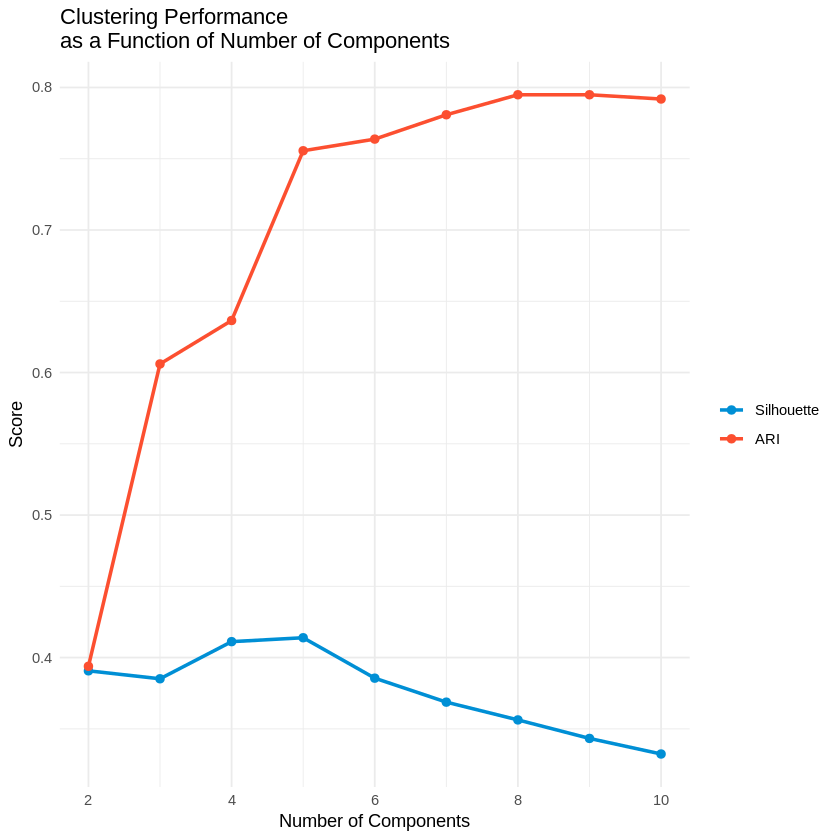

In [ ]:
components <- 2:10  # Corresponding components

# Create a data frame for plotting
results_df <- data.frame(
  n_components = components,
  Silhouette = silhouette_scores,
  ARI = ari_scores
)

# Reshape data for ggplot2
results_long <- reshape2::melt(results_df, id.vars = "n_components")

# Plotting using ggplot2
ggplot(results_long, aes(x = n_components, y = value, color = variable)) +
  geom_line(size = 1) +
  geom_point(size = 2) +
  scale_color_manual(values = c("Silhouette" = "#008fd5", "ARI" = "#fc4f30")) +
  labs(
    x = "Number of Components",
    y = "Score",
    title = "Clustering Performance\nas a Function of Number of Components"
  ) +
  theme_minimal() +
  theme(legend.title = element_blank())

Based on the ARI score, 8 is the optimal of components to reduce to.

# **Credits**

**The END** <br>
**Authors: Dr. Samir Gupta, Dr. Matthew McCoy, Jia Li Dong (M.S.) & ICBI AIM-AHEAD Team**

<img src="https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/HIDSLOGO.AA1.jpg" alt="Powered by" width="500"/>